In [413]:
import polars as pl
import polars.selectors as cs
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

In [414]:
# import the data
raw_df = pl.read_csv('mnist_train_small.csv')
raw_df.head()

6,0,0_duplicated_0,0_duplicated_1,0_duplicated_2,0_duplicated_3,0_duplicated_4,0_duplicated_5,0_duplicated_6,0_duplicated_7,0_duplicated_8,0_duplicated_9,0_duplicated_10,0_duplicated_11,0_duplicated_12,0_duplicated_13,0_duplicated_14,0_duplicated_15,0_duplicated_16,0_duplicated_17,0_duplicated_18,0_duplicated_19,0_duplicated_20,0_duplicated_21,0_duplicated_22,0_duplicated_23,0_duplicated_24,0_duplicated_25,0_duplicated_26,0_duplicated_27,0_duplicated_28,0_duplicated_29,0_duplicated_30,0_duplicated_31,0_duplicated_32,0_duplicated_33,0_duplicated_34,…,0_duplicated_553,0_duplicated_554,0_duplicated_555,0_duplicated_556,0_duplicated_557,0_duplicated_558,0_duplicated_559,0_duplicated_560,0_duplicated_561,0_duplicated_562,0_duplicated_563,0_duplicated_564,0_duplicated_565,0_duplicated_566,0_duplicated_567,0_duplicated_568,0_duplicated_569,0_duplicated_570,0_duplicated_571,0_duplicated_572,0_duplicated_573,0_duplicated_574,0_duplicated_575,0_duplicated_576,0_duplicated_577,0_duplicated_578,0_duplicated_579,0_duplicated_580,0_duplicated_581,0_duplicated_582,0_duplicated_583,0_duplicated_584,0_duplicated_585,0_duplicated_586,0_duplicated_587,0_duplicated_588,0_duplicated_589
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [415]:
# select the data
label = raw_df[:, 0]
data = raw_df[:, 1:]

In [416]:
# convert to tensor data
dataT = torch.tensor(data.to_numpy()).float()
labelT = torch.tensor(label.to_numpy()).long()

In [417]:
labelT

tensor([5, 7, 9,  ..., 2, 9, 5])

In [418]:
# split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(dataT, labelT, test_size=0.2, random_state=42)

In [419]:
# # normalize the training and test data
# # remember to change it to torch.float()
# scaler = StandardScaler()
#
# X_train_norm = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
# X_test_norm = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

In [420]:
# create the scaler
X_train_scaler= FunctionTransformer(lambda x: (x / torch.max(X_train)), validate=True)
X_test_scaler= FunctionTransformer(lambda x: (x / torch.max(X_test)), validate=True)

# fit transform
X_train_norm = torch.tensor(X_train_scaler.fit_transform(X_train), dtype=torch.float32)
X_test_norm = torch.tensor(X_test_scaler.fit_transform(X_test), dtype=torch.float32)

/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_28081/881578220.py:6: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/f8/vcqysvdd39j1b3z4bt0ttjt40000gn/T/ipykernel_28081/881578220.py:7: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [421]:
# remember we need to covert this to tensor
type(scaler.fit_transform(X_train))

numpy.ndarray

In [422]:
type(X_train_norm)

torch.Tensor

In [423]:
# create dataset
train_dataset = TensorDataset(X_train_norm, y_train)
test_dataset = TensorDataset(X_test_norm, y_test)

# create dataloader
batchSize = 32
train_loader = DataLoader(train_dataset, batch_size=batchSize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [424]:
# construct the class for the model
class ANN(nn.Module):
    # nUnits is the breath
    # nLayers is the depth
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create a dictionary to store the layers
        # the moduleDict is specifically designed to sotre layers of deep learning network
        # initialize it to be an empty dictionary; special dict from pytorch
        self.layers = nn.ModuleDict()

        self.nLayers = nLayers
        ### input layer
        self.layers['input'] = nn.Linear(784, nUnits)

        ### generate the hidden layers
        # loop through the number of nLayers - which is an input
        for i in range(nLayers):
            # here we are defining it a name and calling it hidden
            # every hidden layer has the same number of units within a model
            self.layers[f"hidden{i}"] = nn.Linear(nUnits, nUnits)

        ### output layer
        self.layers['output'] = nn.Linear(nUnits, 10)

    # forward pass
    def forward(self, x):
        x = F.relu(self.layers['input'](x))

        # hidden layers
        ### pass x into all of the hidden layers
        for i in range(self.nLayers):
            x = F.relu(self.layers[f"hidden{i}"](x))

        # return outpput layer
        x = self.layers['output'](x)

        return x

In [425]:
# more simplified from Claude AI
class ANNmodel(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create a dictionary to store the layers
        self.layers = nn.ModuleDict()

        ### input layer
        self.layers['input'] = nn.Linear(784, nUnits)

        ### generate the hidden layers
        for i in range(nLayers):
            self.layers[f"hidden{i}"] = nn.Linear(nUnits, nUnits)

        ### output layer
        self.layers['output'] = nn.Linear(nUnits, 10)

    # forward pass
    def forward(self, x):
        x = F.relu(self.layers['input'](x))

        # hidden layers
        # Use the number of hidden layers directly from the ModuleDict
        for i in range(len(self.layers) - 2):  # -2 for input and output layers
            x = F.relu(self.layers[f"hidden{i}"](x))

        # return output layer
        x = x = F.log_softmax(self.layers['output'](x), dim=1)

        return x

In [426]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 64
nLayers = 4
net = ANNmodel(nUnitsPerLayer,nLayers)
net

ANNmodel(
  (layers): ModuleDict(
    (input): Linear(in_features=784, out_features=64, bias=True)
    (hidden0): Linear(in_features=64, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=64, bias=True)
    (hidden2): Linear(in_features=64, out_features=64, bias=True)
    (hidden3): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [427]:
# create model componenets
def createANNnet(train_loader, nUnits, nLayers, learningRate=0.01, epochStep=10, gamma=1/2, ):
    model = ANNmodel(nUnits, nLayers)
    lossfunc = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

    step_size = len(train_loader) * epochStep
    schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    return model, lossfunc, optimizer, schedular

In [428]:
# function to train the model
# train the model
def trainModel(train_loader, test_loader, nUnits, nLayers, numepochs=100, toggleDynamic=True):
    # define an empty list
    training_progress = pl.DataFrame(
        schema=[
            ('iteration', pl.Int64),
            ('epoch', pl.Int64),
            ('train_loss', pl.Float64),
            ('train_acc', pl.Float64),
            ('test_loss', pl.Float64),
            ('test_acc', pl.Float64),
            ('learning_rate', pl.Float64)
        ]
    )
    iteration = 0

    # create the ann Model
    model, lossfunc, optimizer, schedular = createANNnet(
        train_loader, nUnits, nLayers, learningRate=0.01, epochStep=10, gamma=1/2,
    )

    # get test data once (since we are using a test_loader that loads all data at once)
    X_testTL, y_testTL = next(iter(test_loader))

    # training looop
    for epoch in range(numepochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0

        # iterate through the training batches
        for X_trainTL, y_trainTL in train_loader:
            yhat_train = model(X_trainTL)
            train_loss = lossfunc(yhat_train, y_trainTL)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if toggleDynamic:
                schedular.step()
                current_lrs = schedular.get_last_lr()[0]
            else:
                current_lrs = optimizer.param_groups[0]['lr']

            # get accuracy
            train_matches = (torch.argmax(yhat_train, axis=1) == y_trainTL).float()
            train_acc = 100 * torch.mean(train_matches)

            # number of batches - a counter for how many batches were processed in this epoch
            # epoch_train_loss = this is a running of the total of the trainin gloss for all the batches in the current epoch
            # epoch_train_loss / num_batches  computes the average t raining loss per batch during the epoch
            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_acc.item()

            num_batches += 1

        # end of epoch: evaluate test Once
        model.eval()
        with torch.no_grad():
            yhat_test = model(X_testTL)
            test_loss = lossfunc(yhat_test, y_testTL)
            test_matches = (torch.argmax(yhat_test, axis=1) ==y_testTL).float()
            test_acc = 100 * torch.mean(test_matches)

        # log single row per epoch
        new_row = pl.DataFrame([{
            'iteration':iteration,
            'epoch':epoch,
            'train_loss': epoch_train_loss / num_batches,
            'train_acc' : epoch_train_acc / num_batches,
            'test_loss' : test_loss.item(),
            'test_acc' : test_acc.item(),
            'learning_rate' : current_lrs
        }])

        # add row to the dataframe
        training_progress = pl.concat([training_progress, new_row])
        iteration += 1

        # this matches withe the epoch step
        if epoch % 10 == 0 or epoch == numepochs -1 :
            print(
                f"Epoch {epoch+1}/{numepochs} - "
                f"Training: Loss={epoch_train_loss / num_batches:.4f}, "
                f"Accuracy={epoch_train_acc / num_batches:.2f}% | "
                f"Testing: Loss={test_loss.item():.4f}, "
                f"Accuracy={test_acc.item():.2f}% | "
                f"Learning Rate: {current_lrs:.6f}"
            )
    return training_progress, model

In [429]:
# Claude AI suggestion to stop the model if no improvement to save computational power
# function to train the model with early stopping
def trainModel2(train_loader, test_loader, nUnits, nLayers, numepochs=100, toggleDynamic=True):
    # define an empty list
    training_progress = pl.DataFrame(
        schema=[
            ('iteration', pl.Int64),
            ('epoch', pl.Int64),
            ('train_loss', pl.Float64),
            ('train_acc', pl.Float64),
            ('test_loss', pl.Float64),
            ('test_acc', pl.Float64),
            ('learning_rate', pl.Float64)
        ]
    )
    iteration = 0

    # create the ann Model
    model, lossfunc, optimizer, schedular = createANNnet(
        train_loader, nUnits, nLayers, learningRate=0.01, epochStep=10, gamma=1/2,
    )

    # get test data once (since we are using a test_loader that loads all data at once)
    X_testTL, y_testTL = next(iter(test_loader))

    # Early stopping parameters
    patience = 30
    best_loss = float('inf')
    no_improve_count = 0
    best_model = None
    import copy  # Add this import at the top of the file

    # training loop
    for epoch in range(numepochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_acc = 0
        num_batches = 0

        # iterate through the training batches
        for X_trainTL, y_trainTL in train_loader:
            yhat_train = model(X_trainTL)
            train_loss = lossfunc(yhat_train, y_trainTL)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if toggleDynamic:
                schedular.step()
                current_lrs = schedular.get_last_lr()[0]
            else:
                current_lrs = optimizer.param_groups[0]['lr']

            # get accuracy
            train_matches = (torch.argmax(yhat_train, axis=1) == y_trainTL).float()
            train_acc = 100 * torch.mean(train_matches)

            # number of batches - a counter for how many batches were processed in this epoch
            # epoch_train_loss = this is a running of the total of the training loss for all the batches in the current epoch
            # epoch_train_loss / num_batches  computes the average training loss per batch during the epoch
            epoch_train_loss += train_loss.item()
            epoch_train_acc += train_acc.item()

            num_batches += 1

        # end of epoch: evaluate test Once
        model.eval()
        with torch.no_grad():
            yhat_test = model(X_testTL)
            test_loss = lossfunc(yhat_test, y_testTL)
            test_matches = (torch.argmax(yhat_test, axis=1) == y_testTL).float()
            test_acc = 100 * torch.mean(test_matches)

        # log single row per epoch
        new_row = pl.DataFrame([{
            'iteration': iteration,
            'epoch': epoch,
            'train_loss': epoch_train_loss / num_batches,
            'train_acc': epoch_train_acc / num_batches,
            'test_loss': test_loss.item(),
            'test_acc': test_acc.item(),
            'learning_rate': current_lrs
        }])

        # add row to the dataframe
        training_progress = pl.concat([training_progress, new_row])
        iteration += 1

        # Early stopping check
        if test_loss < best_loss:
            best_loss = test_loss.item()
            no_improve_count = 0
            # Save best model
            best_model = copy.deepcopy(model)
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping at epoch {epoch+1} - No improvement for {patience} epochs")
                break

        # this matches with the epoch step
        if epoch % 10 == 0 or epoch == numepochs - 1:
            print(
                f"Epoch {epoch+1}/{numepochs} - "
                f"Training: Loss={epoch_train_loss / num_batches:.4f}, "
                f"Accuracy={epoch_train_acc / num_batches:.2f}% | "
                f"Testing: Loss={test_loss.item():.4f}, "
                f"Accuracy={test_acc.item():.2f}% | "
                f"Learning Rate: {current_lrs:.6f}"
            )

    # Return the best model instead of the last model
    return training_progress, best_model if best_model is not None else model

In [430]:
# define the model parameters
numlayers = range(1, 4)
numunits = np.arange(50, 300, 50)

In [431]:
# create a loop for those model parameters and start the expperiment

all_results = []
for unit in numunits:
    for layer in numlayers:
        training_progress, best_model = trainModel2(train_loader, test_loader, nUnits=unit, nLayers=layer, numepochs=100, toggleDynamic=True)

        # we need create a columns to annonate the number of unit and layers in each loop
        training_progress = (
            training_progress
            .with_columns(
                number_units=pl.lit(unit),
                number_layers=pl.lit(layer)
            )
        )
        # append the returning dataframe to all_results
        all_results.append(training_progress)

combined_results = pl.concat(all_results)

Epoch 1/100 - Training: Loss=0.4099, Accuracy=87.18% | Testing: Loss=0.3480, Accuracy=89.70% | Learning Rate: 0.010000
Epoch 11/100 - Training: Loss=0.0588, Accuracy=98.32% | Testing: Loss=0.2469, Accuracy=95.17% | Learning Rate: 0.005000
Epoch 21/100 - Training: Loss=0.0164, Accuracy=99.46% | Testing: Loss=0.3459, Accuracy=95.35% | Learning Rate: 0.002500
Epoch 31/100 - Training: Loss=0.0010, Accuracy=99.98% | Testing: Loss=0.4406, Accuracy=95.78% | Learning Rate: 0.001250
Early stopping at epoch 34 - No improvement for 30 epochs
Epoch 1/100 - Training: Loss=0.4585, Accuracy=85.85% | Testing: Loss=0.3403, Accuracy=90.45% | Learning Rate: 0.010000
Epoch 11/100 - Training: Loss=0.0633, Accuracy=98.11% | Testing: Loss=0.2400, Accuracy=95.15% | Learning Rate: 0.005000
Epoch 21/100 - Training: Loss=0.0206, Accuracy=99.48% | Testing: Loss=0.3088, Accuracy=95.32% | Learning Rate: 0.002500
Epoch 31/100 - Training: Loss=0.0027, Accuracy=99.91% | Testing: Loss=0.4473, Accuracy=95.35% | Learning

In [432]:
# inspect the data
combined_results.head()

iteration,epoch,train_loss,train_acc,test_loss,test_acc,learning_rate,number_units,number_layers
i64,i64,f64,f64,f64,f64,f64,i32,i32
0,0,0.409902,87.180611,0.347965,89.700005,0.01,50,1
1,1,0.231366,93.167585,0.258432,92.349998,0.01,50,1
2,2,0.183377,94.457665,0.248038,93.275002,0.01,50,1
3,3,0.169616,94.927355,0.234673,93.550003,0.01,50,1
4,4,0.161112,95.271794,0.259947,93.550003,0.01,50,1


In [433]:
# grouped the data based on number_units, number_layers, epoch
grouped_results = (
    combined_results
    .group_by('number_layers', 'number_units', 'epoch')
    .agg(
        cs.numeric().mean().name.prefix('mean_')
    )
    .sort(['number_units', 'number_layers', 'epoch'], descending=False)

)

In [434]:
# instead grouped results - the top few rows are the best performing model
grouped_results.sort('mean_test_acc', descending=True).head()

number_layers,number_units,epoch,mean_iteration,mean_train_loss,mean_train_acc,mean_test_loss,mean_test_acc,mean_learning_rate
i32,i32,i64,f64,f64,f64,f64,f64,f64
1,150,22,22.0,0.001672,99.9499,0.313334,96.900002,0.0025
1,150,25,25.0,0.00173,99.9499,0.333169,96.875,0.0025
1,150,23,23.0,0.001344,99.956162,0.31146,96.824997,0.0025
1,150,21,21.0,0.003194,99.8998,0.297384,96.800003,0.0025
1,150,32,32.0,0.000359,99.981212,0.370671,96.675003,0.00125


In [435]:
fig = px.scatter(
    grouped_results,
    x='number_units',
    y='mean_test_acc',
    color='epoch',
    facet_col='number_layers',
    color_continuous_scale='Plasma'
)

fig.update_layout(template='ggplot2', width=800)

In [436]:
import plotly.express as px

# After your experiments, visualize results
fig = px.scatter_3d(
    grouped_results,
    x='number_units',
    y='number_layers',
    z='mean_test_acc',
    color='epoch',
    size='mean_test_acc',
    hover_data=['mean_train_loss', 'mean_test_loss'],
    color_continuous_scale='Plasma_r'
)

fig.update_layout(template='ggplot2', width=600, height=600)
fig.update_traces(marker=dict(line=dict(width=0.2, color='darkslategrey')))
fig.show()

In [437]:
grouped_nLayers = (
    combined_results
    .group_by('number_layers', 'epoch')
    .agg(
        cs.numeric().mean().name.prefix('mean_')
    )
    .sort(['number_layers',], descending=False)
    .sort('epoch', descending=False)

)

In [438]:
grouped_nUnits = (
    combined_results
    .group_by('number_units', 'epoch')
    .agg(
        cs.numeric().mean().name.prefix('mean_')
    )
    .sort(['number_units',], descending=False)
    .sort('epoch', descending=False)
)

In [439]:
grouped_nUnits.select(pl.col('number_units').unique())

number_units
i32
50
100
150
200
250


Text(0, 0.5, 'Accuracy')

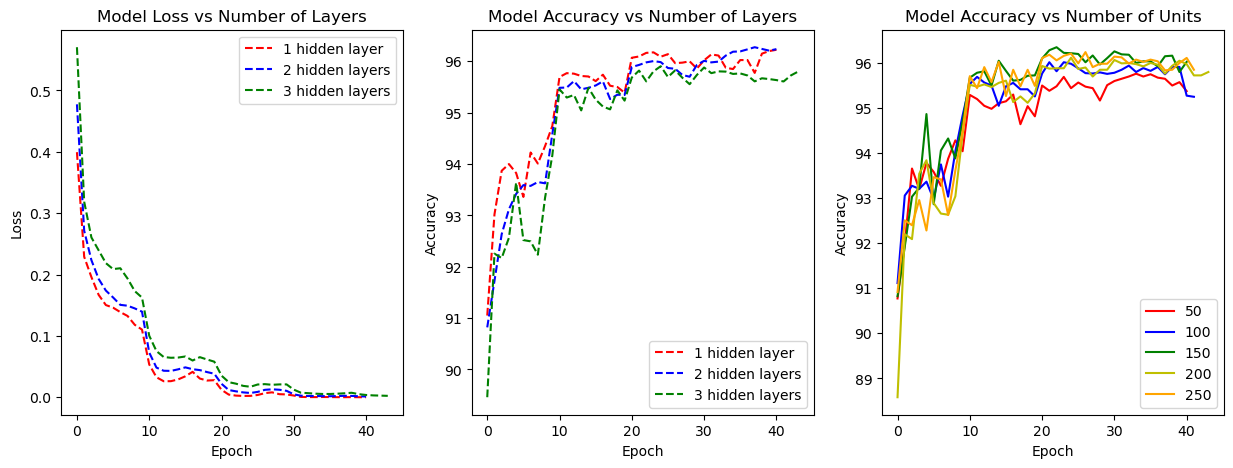

In [440]:
# inspect the loss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].plot(grouped_nLayers.filter(pl.col('number_layers').eq(1)).select('mean_train_loss'), 'r--')
ax[0].plot(grouped_nLayers.filter(pl.col('number_layers').eq(2)).select('mean_train_loss'), 'b--')
ax[0].plot(grouped_nLayers.filter(pl.col('number_layers').eq(3)).select('mean_train_loss'), 'g--')
ax[0].legend(['1 hidden layer', '2 hidden layers', '3 hidden layers'])
ax[0].set_title('Model Loss vs Number of Layers')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(grouped_nLayers.filter(pl.col('number_layers').eq(1)).select('mean_test_acc'), 'r--')
ax[1].plot(grouped_nLayers.filter(pl.col('number_layers').eq(2)).select('mean_test_acc'), 'b--')
ax[1].plot(grouped_nLayers.filter(pl.col('number_layers').eq(3)).select('mean_test_acc'), 'g--')
ax[1].legend(['1 hidden layer', '2 hidden layers', '3 hidden layers'])
ax[1].set_title('Model Accuracy vs Number of Layers')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

ax[2].plot(grouped_nUnits.filter(pl.col('number_units').eq(50)).select('mean_test_acc'), 'r')
ax[2].plot(grouped_nUnits.filter(pl.col('number_units').eq(100)).select('mean_test_acc'), 'b')
ax[2].plot(grouped_nUnits.filter(pl.col('number_units').eq(150)).select('mean_test_acc'), 'g')
ax[2].plot(grouped_nUnits.filter(pl.col('number_units').eq(200)).select('mean_test_acc'), 'y')
ax[2].plot(grouped_nUnits.filter(pl.col('number_units').eq(250)).select('mean_test_acc'), 'orange')
ax[2].legend(['50', '100', '150', '200', '250'])
ax[2].set_title('Model Accuracy vs Number of Units')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')

